# Task Solving with Code Generation, Execution and Debugging

In this notebook, we demonstrate how to use `AssistantAgent` and `UserProxyAgent` to write code and execute the code. Here `AssistantAgent` is an LLM-based agent that can write Python code (in a Python coding block) for a user to execute for a given task. `UserProxyAgent` is an agent which serves as a proxy for the human user to execute the code written by `AssistantAgent`, or automatically execute the code. Depending on the setting of `human_input_mode` and `max_consecutive_auto_reply`, the `UserProxyAgent` either solicits feedback from the human user or returns auto-feedback based on the result of code execution (success or failure and corresponding outputs) to `AssistantAgent`. `AssistantAgent` will debug the code and suggest new code if the result contains error. The two agents keep communicating to each other until the task is done.

````{=mdx}
:::info Requirements
Install the following packages before running the code below:
```bash
pip install ag2[openai] matplotlib yfinance
```

For more information, please refer to the [installation guide](https://docs.ag2.ai/latest/docs/user-guide/basic-concepts/installing-ag2).
:::
````

In [1]:
from IPython.display import Image, display
import os
import autogen
from autogen.coding import LocalCommandLineCodeExecutor

from dotenv import load_dotenv
filter_dict = {"tags": "gpt-4o-mini"}
#llm_config = autogen.LLMConfig.from_json(path="OAI_CONFIG_LIST", cache_seed=41, temperature=0).where(**filter_dict)

# When using a single openai endpoint, you can use the following:
llm_config = autogen.LLMConfig(api_type="openai", model="gpt-4o-mini", api_key=os.environ.get("OPENAI_API_KEY"), cache_seed=41, temperature=0)

/opt/anaconda3/envs/csi/lib/python3.11/site-packages/pydantic/_internal/_fields.py:161: UserWarning: Field "model_client_cls" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/opt/anaconda3/envs/csi/lib/python3.11/site-packages/pydantic/_internal/_fields.py:161: UserWarning: Field "model_client_cls" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/opt/anaconda3/envs/csi/lib/python3.11/site-packages/pydantic/_internal/_fields.py:161: UserWarning: Field "model_client_cls" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/opt/anaconda3/envs/csi/lib/python3.11/site-packages/pydantic/_internal/_fields.py:161: UserWarning: Field "model_client_cls" has confli

## Example Task: Check Stock Price Change

In the example below, let's see how to use the agents in AutoGen to write a python script and execute the script. This process involves constructing a `AssistantAgent` to serve as the assistant, along with a `UserProxyAgent` that acts as a proxy for the human user. In this example demonstrated below, when constructing the `UserProxyAgent`,  we select the `human_input_mode` to "NEVER". This means that the `UserProxyAgent` will not solicit feedback from the human user. It stops replying when the limit defined by `max_consecutive_auto_reply` is reached, or when `is_termination_msg()` returns true for the received message.

In [ ]:
# create an AssistantAgent named "assistant"
with llm_config:
    assistant = autogen.AssistantAgent(name="assistant")

# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config={
        # the executor to run the generated code
        "executor": LocalCommandLineCodeExecutor(work_dir="assistant_and_userproxy_tutorial"),
    },
)
# the assistant receives a message from the user_proxy, which contains the task description
chat_res = user_proxy.initiate_chat(
    assistant,
    message="""What date is today? Compare the year-to-date gain for META and TESLA.""",
    summary_method="reflection_with_llm",
)

user_proxy (to assistant):

What date is today? Compare the year-to-date gain for META and TESLA.

--------------------------------------------------------------------------------
assistant (to user_proxy):

To determine today's date and compare the year-to-date gain for META (Meta Platforms, Inc.) and TESLA (Tesla, Inc.), I will follow these steps:

1. Get today's date.
2. Fetch the current stock prices for META and TESLA.
3. Fetch the stock prices for META and TESLA at the beginning of the year.
4. Calculate the year-to-date gain for both stocks.

Let's start by getting today's date. I will use Python to do this.

```python
# filename: get_today_date.py
from datetime import datetime

# Get today's date
today = datetime.now().date()
print(today)
```

Please execute this code to get today's date.

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING CODE BLOCK (inferred language is python)...
user_proxy (to assistant):

exitcode: 0 (execu

The example above involves code execution. In AutoGen, code execution is triggered automatically by the `UserProxyAgent` when it detects an executable code block in a received message and no human user input is provided. 
Users have the option to specify a different working directory by setting the `work_dir` argument when constructing a new instance of the `LocalCommandLineCodeExecutor`.
For Docker-based or Jupyter kernel-based code execution, please refer to 
[Code Executors Tutorial](https://docs.ag2.ai/latest/docs/user-guide/advanced-concepts/code-execution) for more information.

#### Check chat results
The `initiate_chat` method returns a `ChatResult` object, which is a dataclass object storing information about the chat. Currently, it includes the following attributes:

- `chat_history`: a list of chat history.
- `summary`: a string of chat summary. A summary is only available if a summary_method is provided when initiating the chat.
- `cost`: a tuple of (total_cost, total_actual_cost), where total_cost is a dictionary of cost information, and total_actual_cost is a dictionary of information on the actual incurred cost with cache.
- `human_input`: a list of strings of human inputs solicited during the chat. (Note that since we are setting `human_input_mode` to `NEVER` in this notebook, this list is always empty.)

In [3]:
print("Chat history:", chat_res.chat_history)

print("Summary:", chat_res.summary)
print("Cost info:", chat_res.cost)

Chat history: [{'content': 'What date is today? Compare the year-to-date gain for META and TESLA.', 'role': 'assistant', 'name': 'user_proxy'}, {'content': "To determine today's date and compare the year-to-date gain for META (Meta Platforms, Inc.) and TESLA (Tesla, Inc.), I will follow these steps:\n\n1. Get today's date.\n2. Fetch the current stock prices for META and TESLA.\n3. Fetch the stock prices for META and TESLA at the beginning of the year.\n4. Calculate the year-to-date gain for both stocks.\n\nLet's start by getting today's date. I will use Python to do this.\n\n```python\n# filename: get_today_date.py\nfrom datetime import datetime\n\n# Get today's date\ntoday = datetime.now().date()\nprint(today)\n```\n\nPlease execute this code to get today's date.", 'role': 'user', 'name': 'assistant'}, {'content': 'exitcode: 0 (execution succeeded)\nCode output: 2025-06-30\n', 'role': 'assistant', 'name': 'user_proxy'}, {'content': "Today's date is June 30, 2025. \n\nNext, I will fetc

## Example Task: Plot Chart

In [4]:
# followup of the previous question
user_proxy.send(
    recipient=assistant,
    message="""Plot a chart of their stock price change YTD. Save the data to stock_price_ytd.csv, and save the plot to stock_price_ytd.png.""",
)

user_proxy (to assistant):

Plot a chart of their stock price change YTD. Save the data to stock_price_ytd.csv, and save the plot to stock_price_ytd.png.

--------------------------------------------------------------------------------
assistant (to user_proxy):

To plot a chart of the stock price changes year-to-date (YTD) for META and TESLA, and to save the data to a CSV file and the plot to a PNG file, I will follow these steps:

1. Prepare the data for META and TESLA, including their start of year and current prices.
2. Create a plot showing the price changes.
3. Save the data to a CSV file named `stock_price_ytd.csv`.
4. Save the plot as `stock_price_ytd.png`.

Here’s the complete Python code to accomplish this:

```python
# filename: plot_stock_price_ytd.py
import pandas as pd
import matplotlib.pyplot as plt

# Define the stock data
stocks_data = {
    'META': {'current_price': 733.6300048828125, 'start_of_year_price': 598.2470703125},
    'TSLA': {'current_price': 323.6300048828

Let's display the generated figure.

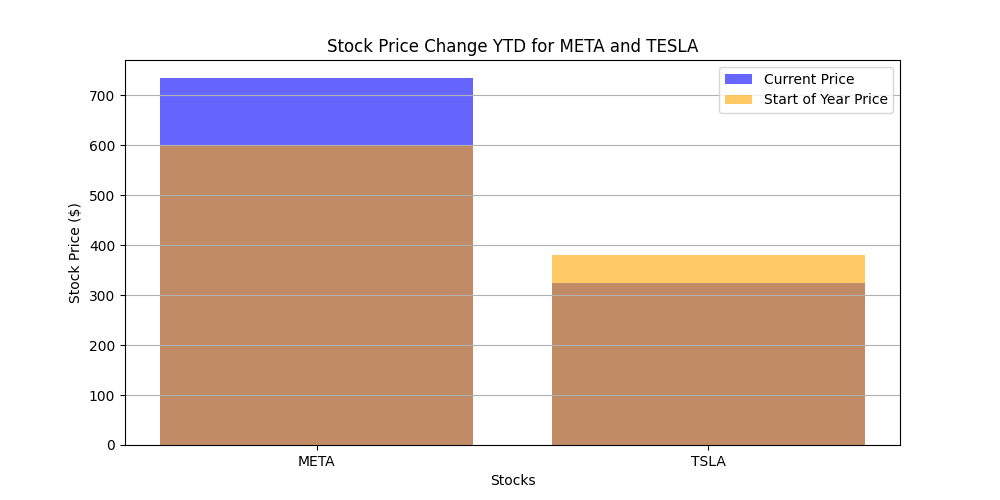

In [5]:
try:
    image = Image(filename="coding/stock_price_ytd.png")
    display(image)
except FileNotFoundError:
    print("Image not found. Please check the file name and modify if necessary.")

Let's display the raw data collected and saved from previous chat as well.

In [6]:
# Path to your CSV file
file_path = "coding/stock_price_ytd.csv"
try:
    with open(file_path, encoding="utf-8") as file:
        # Read each line in the file
        for line in file:
            # Split the line into a list using the comma as a separator
            row = line.strip().split(",")
            # Print the list representing the current row
            print(row)
except FileNotFoundError:
    print("File not found. Please check the file name and modify if necessary.")

['Stock', 'Start of Year Price', 'Current Price']
['META', '598.2470703125', '733.6300048828125']
['TSLA', '379.2799987792969', '323.6300048828125']


## Example Task: Use User Defined Message Function to let Agents Analyze data Collected

Let's create a user defined message to let the agents analyze the raw data and write a blogpost. The function is supposed to take `sender`, `recipient` and `context` as inputs and outputs a string of message.

**kwargs from `initiate_chat` will be used as `context`. Take the following code as an example, the `context` includes a field `file_name` as provided in `initiate_chat`. In the user defined message function `my_message_generator`, we are reading data from the file specified by this filename.


In [7]:
def my_message_generator(sender, recipient, context):
    # your CSV file
    file_name = context.get("file_name")
    try:
        with open(file_name, encoding="utf-8") as file:
            file_content = file.read()
    except FileNotFoundError:
        file_content = "No data found."
    return "Analyze the data and write a brief but engaging blog post. \n Data: \n" + file_content


# followup of the previous question
chat_res = user_proxy.initiate_chat(
    recipient=assistant,
    message=my_message_generator,
    file_name="coding/stock_price_ytd.csv",
    summary_method="reflection_with_llm",
    summary_args={"summary_prompt": "Return the blog post in Markdown format."},
)

user_proxy (to assistant):

Analyze the data and write a brief but engaging blog post. 
 Data: 
Stock,Start of Year Price,Current Price
META,598.2470703125,733.6300048828125
TSLA,379.2799987792969,323.6300048828125


--------------------------------------------------------------------------------
assistant (to user_proxy):

To create an engaging blog post based on the provided stock data, I will first analyze the data to identify trends and insights. Then, I will write a brief blog post that highlights these findings.

### Analysis of the Data
1. **META (Meta Platforms, Inc.)**:
   - Start of Year Price: $598.25
   - Current Price: $733.63
   - Price Change: $733.63 - $598.25 = $135.38
   - Percentage Increase: (135.38 / 598.25) * 100 ≈ 22.65%

2. **TSLA (Tesla, Inc.)**:
   - Start of Year Price: $379.28
   - Current Price: $323.63
   - Price Change: $323.63 - $379.28 = -$55.65
   - Percentage Decrease: (-55.65 / 379.28) * 100 ≈ -14.68%

### Blog Post
Now, I will write the blog post ba

Let's check the summary of the chat

In [8]:
print(chat_res.summary)

Sure! Here’s the blog post formatted in Markdown:

```markdown
# Stock Market Insights: A Tale of Two Giants

As we navigate through the ever-evolving landscape of the stock market, two companies stand out with contrasting fortunes: Meta Platforms, Inc. (META) and Tesla, Inc. (TSLA). 

## META: Soaring to New Heights
Starting the year at a price of $598.25, META has seen a remarkable surge, currently trading at $733.63. This impressive increase of approximately 22.65% reflects the company's robust performance and investor confidence. As Meta continues to innovate and expand its reach in the digital space, it seems poised for further growth.

## TSLA: A Rocky Road
In stark contrast, Tesla has faced challenges this year. Beginning the year at $379.28, TSLA's current price of $323.63 marks a decline of about 14.68%. This downturn raises questions about the company's market strategies and the broader implications for the electric vehicle industry. Investors will be keen to see how Tesla ad

This is the blog post that the agents generated.

# A Comparative Analysis of META and TESLA Stocks in Early 2024

In the first quarter of 2024, the stock market saw some interesting movements in the tech sector. Two companies that stood out during this period were META and TESLA. 

META, the social media giant, had an average stock price of 403.53 during this period. The highest it reached was 519.83, while the lowest was 344.47. The standard deviation, a measure of how spread out the prices were, was 100.72.

On the other hand, TESLA, the electric vehicle and clean energy company, had an average stock price of 219.54. The stock reached a high of 248.42 and a low of 171.76. The standard deviation for TESLA was 41.68.

These figures show that both META and TESLA had their ups and downs during this period. However, the higher standard deviation for META indicates that its stock price fluctuated more compared to TESLA.

As we move further into 2024, it will be interesting to see how these trends evolve. Will META and TESLA continue on their current trajectories, or will we see a shift in the market dynamics? Only time will tell.

Let's check how much the above chat cost

In [9]:
print(chat_res.cost)

{'usage_including_cached_inference': {'total_cost': 0.004331999999999999, 'gpt-4o-mini-2024-07-18': {'cost': 0.004331999999999999, 'prompt_tokens': 17236, 'completion_tokens': 2911, 'total_tokens': 20147}}, 'usage_excluding_cached_inference': {'total_cost': 0.004331999999999999, 'gpt-4o-mini-2024-07-18': {'cost': 0.004331999999999999, 'prompt_tokens': 17236, 'completion_tokens': 2911, 'total_tokens': 20147}}}
